In [1]:
import os
import subprocess
from pathlib import Path
import torch
from mmdet3d.evaluation.metrics import nuscenes_metric as nus_metric
from mmdet3d.evaluation.metrics.nuscenes_metric import output_to_nusc_box
import json 
from pyquaternion import Quaternion
from nuscenes.utils.data_classes import Box
from nuscenes.utils.geometry_utils import transform_matrix
import operator
from functools import reduce
from pathlib import Path
import numpy as np
from nuscenes.nuscenes import NuScenes
from nuscenes.eval.detection.config import config_factory
from nuscenes.eval.detection.evaluate import NuScenesEval
from nuscenes.utils.data_classes import RadarPointCloud
from classes import cls_attr_dist, class_names, mini_val_tokens
from custom_env import home_dir, output_dir, preds_dir, model_dir, is_set_to_mini
from custom_env import dataset_root as dataroot
from nuscenes.utils.geometry_utils import view_points, box_in_image, BoxVisibility

import nuscenes_render

ModuleNotFoundError: No module named 'mmdet3d'

In [3]:
eval_set_map = {
        'v1.0-mini': 'mini_val',
        'v1.0-trainval': 'val',
        'v1.0-test': 'test'
    }

dataset_version = 'v1.0-mini' if is_set_to_mini() else 'v1.0-trainval'
try:
    eval_version = 'detection_cvpr_2019'
    eval_config = config_factory(eval_version)
except:
    eval_version = 'cvpr_2019'
    eval_config = config_factory(eval_version)
    

DETECTION_THRESHOLD = 0.35

backend_args = None
nusc = NuScenes(version=dataset_version, dataroot = dataroot)
ann_file = f'{dataroot}nuscenes_infos_val.pkl'
metric='bbox'

pcd_path = f"{dataroot}/samples/LIDAR_TOP/"
mmdet_path = f"{home_dir}/software/mmdetection3d"
pcd_list = os.listdir(pcd_path)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.393 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [23]:
def __load_ego_veh(self, sample_token:str):
    sample = nusc.get('sample', sample_token)
    sd_record = nusc.get('sample_data', sample['data']['LIDAR_TOP'])
    return nusc.get('ego_pose', sd_record['ego_pose_token'])

print(__load_ego_veh(nusc, "b5989651183643369174912bc5641d3b"))

{'token': '65e07a70e6b5404a87bf34e49d4c0924', 'timestamp': 1538984233547259, 'rotation': [0.7975669682580437, 0.005315502266279129, -0.002909268422510148, -0.6031999774010075], 'translation': [715.6860124782239, 1810.0473004751316, 0.0]}


In [20]:
import random

sample = "b5989651183643369174912bc5641d3b"
sample = nusc.get('sample', sample)

In [5]:
# sd_record = nusc.get('sample', sample['data'])
# sd_record
for token in sample['data']:
    sd_record = nusc.get('sample_data', sample['data'][token])
    print(sd_record['filename'])


samples/RADAR_FRONT/n015-2018-10-08-15-36-50+0800__RADAR_FRONT__1538984233560834.pcd
samples/RADAR_FRONT_LEFT/n015-2018-10-08-15-36-50+0800__RADAR_FRONT_LEFT__1538984233559954.pcd
samples/RADAR_FRONT_RIGHT/n015-2018-10-08-15-36-50+0800__RADAR_FRONT_RIGHT__1538984233580978.pcd
samples/RADAR_BACK_LEFT/n015-2018-10-08-15-36-50+0800__RADAR_BACK_LEFT__1538984233568518.pcd
samples/RADAR_BACK_RIGHT/n015-2018-10-08-15-36-50+0800__RADAR_BACK_RIGHT__1538984233550067.pcd
samples/LIDAR_TOP/n015-2018-10-08-15-36-50+0800__LIDAR_TOP__1538984233547259.pcd.bin
samples/CAM_FRONT/n015-2018-10-08-15-36-50+0800__CAM_FRONT__1538984233512470.jpg
samples/CAM_FRONT_RIGHT/n015-2018-10-08-15-36-50+0800__CAM_FRONT_RIGHT__1538984233520339.jpg
samples/CAM_BACK_RIGHT/n015-2018-10-08-15-36-50+0800__CAM_BACK_RIGHT__1538984233527893.jpg
samples/CAM_BACK/n015-2018-10-08-15-36-50+0800__CAM_BACK__1538984233537525.jpg
samples/CAM_FRONT_LEFT/n015-2018-10-08-15-36-50+0800__CAM_FRONT_LEFT__1538984233504844.jpg
samples/CAM_BAC

In [6]:
sd_record = nusc.get('sample_data', sample['data']['LIDAR_TOP'])
sd_record['filename']

'samples/LIDAR_TOP/n015-2018-10-08-15-36-50+0800__LIDAR_TOP__1538984233547259.pcd.bin'

In [7]:
nusc.get('ego_pose', sd_record['ego_pose_token'])

{'token': '65e07a70e6b5404a87bf34e49d4c0924',
 'timestamp': 1538984233547259,
 'rotation': [0.7975669682580437,
  0.005315502266279129,
  -0.002909268422510148,
  -0.6031999774010075],
 'translation': [715.6860124782239, 1810.0473004751316, 0.0]}

In [8]:
from pyquaternion import Quaternion
sd_record = nusc.get('sample_data', sample['data']['LIDAR_TOP'])
pose = nusc.get('ego_pose', sd_record['ego_pose_token'])
q = Quaternion(pose['rotation'])

In [9]:
import math
math.atan2(pose['translation'][1], pose['translation'][0])

1.194264942548287

In [10]:
q.yaw_pitch_roll

psi = q.yaw_pitch_roll[0]

psi/np.pi * 180

-74.19886658134564

In [11]:
from nuscenes.eval.common.utils import quaternion_yaw
# PREFER THIS
rotation = Quaternion(pose['rotation'])
yaw = quaternion_yaw(rotation) / np.pi * 180

yaw

-74.19983164931512

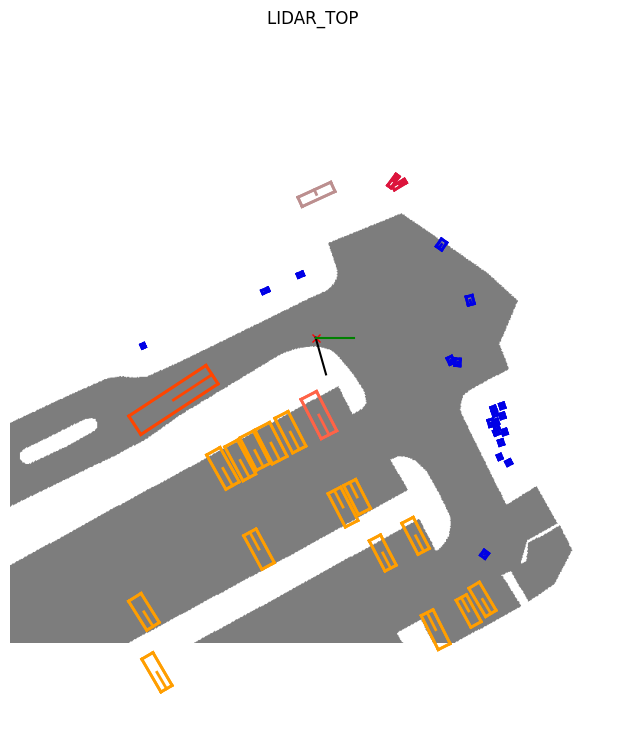

In [12]:
import random

sample = "b5989651183643369174912bc5641d3b"
sample = nusc.get('sample', sample)

nuscenes_render.render_sample_data_with_predictions(sample["data"]["LIDAR_TOP"], nusc=nusc)

# Figure out the coordinate frame
# Plot the yaw on the map below

In [13]:
# nusc.render_sample("b5989651183643369174912bc5641d3b")

In [14]:
scene = nusc.scene[0]
scene

{'token': 'cc8c0bf57f984915a77078b10eb33198',
 'log_token': '7e25a2c8ea1f41c5b0da1e69ecfa71a2',
 'nbr_samples': 39,
 'first_sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'last_sample_token': 'ed5fc18c31904f96a8f0dbb99ff069c0',
 'name': 'scene-0061',
 'description': 'Parked truck, construction, intersection, turn left, following a van'}

In [15]:
def get_ego_pose(token):
    for ego_pose in nusc.ego_pose:
        if ego_pose['token'] == token:
            return ego_pose
    print("Ego pose not found for token", token)
        
get_ego_pose(sample['token'])

Ego pose not found for token b5989651183643369174912bc5641d3b


In [16]:
sample = "b5989651183643369174912bc5641d3b"
sample = nusc.get('sample', sample)

a, boxes, b = nusc.get_sample_data(sample["data"]["LIDAR_TOP"], 
                     box_vis_level=BoxVisibility.ANY,
                     use_flat_vehicle_coordinates=True)

np.degrees(np.arctan2(boxes[0].center[1], boxes[0].center[0]))

-80.82701628613692

In [18]:
nusc.get('ego_pose', nusc.get('sample', sample['token'])['ego_pose_token'])

KeyError: 'ego_pose_token'

In [20]:
boxes[0]

array([  3.58066221, -22.17391881])

In [43]:
b